# Tests and visualizations

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from helpers import *
from implementations import *

## Constants

In [40]:
DATA_PATH = "../data/"
N = 32 # number of columns in data
ratio = 0.9 # ratio of data to use for training
seed = 1 # random seed
d = 9 # degree of polynomial feature expansion
max_iter = 30 # number of iterations for gradient descent

## Load data

In [41]:
def load_one_column(filename, column, data_type='float'):
    """load one column from data"""
    data = np.loadtxt(DATA_PATH + filename, delimiter=",", skiprows=1, unpack=True, usecols=[column], dtype=data_type)
    return data

In [42]:
def load_features(filename):
    """load data features"""
    data = np.loadtxt(DATA_PATH + filename, delimiter=",", skiprows=1, unpack=True, usecols=np.arange(2, N))
    return data

In [43]:
def build_model_data(y, x):
    """Form (y,tX) to get regression data in matrix form."""
    num_samples = len(y)
    fun = lambda e : 0 if e == 'b' else 1 # convert b to 0 and s to 1
    y = [fun(e) for e in y]
    tx = np.c_[np.ones(num_samples), x.T]
    return np.array(y), tx

Load training data

In [44]:
training_predictions = load_one_column("train.csv", 1, 'str')
training_features = load_features("train.csv")

In [45]:
print(training_predictions.shape, training_features.shape)

(250000,) (30, 250000)


In [46]:
training_y, training_tx = build_model_data(training_predictions, training_features)
training_tx_std = standardize(training_tx)[0]
print(training_y.shape, training_tx_std.shape)

(250000,) (250000, 31)


Load test data

In [47]:
test_ids = load_one_column("test.csv", 0)
test_features = load_features("test.csv")

In [48]:
print(test_ids.shape, test_features.shape)

(568238,) (30, 568238)


In [49]:
_, test_tx = build_model_data(test_ids, test_features)
test_tx_std = standardize(test_tx)[0]
print(test_tx_std.shape)

(568238, 31)


## Data visualization
Use this to plot relations between 2 features

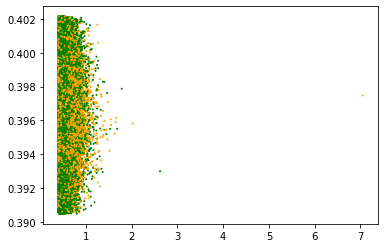

In [50]:
index_a = 20
index_b = 15
y_colors = ['green' if e == 0 else 'orange' for e in training_y]
plt.scatter(training_tx_std[:, index_a], training_tx_std[:, index_b], s=1, c=y_colors)

## Feature expansion

In [51]:
def feature_expansion(tx):
    poly = build_poly(tx[:, 0], d)
    for i in range(1, N-1):
        poly = np.hstack((poly, build_poly(tx[:, i], d)[:, 1:]))
        
    return poly

In [52]:
training_tx_poly = feature_expansion(training_tx_std)

In [53]:
print(training_tx_poly.shape)

(250000, 280)


In [54]:
test_tx_poly = feature_expansion(test_tx_std)

In [55]:
print(test_tx_poly.shape)

(568238, 280)


## Split data

In [56]:
tx_tr, tx_val, y_tr, y_val = split_data(training_tx_poly, training_y, ratio, seed)
print(tx_tr.shape)
print(tx_val.shape)
print(y_tr.shape)
print(y_val.shape)

(225000, 280)
(25000, 280)
(225000,)
(25000,)


## Implementations

In [57]:
def compute_loss(y, tx, w):

    """Calculate the loss using MSE

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N, M)
        w: numpy array of shape=(M,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    e = y - tx@w
    n = y.shape[0]
    
    return (e.T@e/(2*n))


In [58]:
def least_squares(y, tx):
    """Calculate the optimal vector w from the least squares regression, using the normal equations
    
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N, M)
        
    Returns:
        w: the optimal model parameters resulting from the least squares regression
        loss: the MSE loss for the model parameters w.r. to y and tx
    """
    # Normal equations : w* = inverse(tx.T @ tx) @ tx.T @ y -> (tx.T @ tx) @ w* = tx.T @ y
    A = tx.T@tx
    b = tx.T@y
    w = np.linalg.solve(A, b) # Aw = b
    
    loss = compute_loss(y, tx, w)
    
    return (w, loss)

In [59]:
def ridge_regression(y, tx, lambda_):
    """Compute ridge regression using normal equations
    
    Args:
        y: numpy array of shape (N,), N is the number of samples.
        tx: numpy array of shape (N,D), D is the number of features.
        lambda_: scalar.
    
    Returns:
        w: optimal weights, numpy array of shape(D,), D is the number of features.
        loss : the MSE loss for the model parameters w.r. to y and tx
    """
    # Normal equations : w*_ridge = inverse(tx.T @ tx + lambda*I) @ tx.T @ y -> (tx.T @ tx + lambda_prime*I) @ w* = tx.T @ y
    n = y.shape[0]
    d = tx.shape[1]
    lambda_prime = 2*n*lambda_
    
    A = tx.T@tx + lambda_prime*np.identity(d)
    b = tx.T@y
    w = np.linalg.solve(A, b)
    
    loss = compute_loss(y, tx, w) + lambda_*np.sum(w**2)
    
    return (w, loss)

In [60]:
def mean_squared_error_gd(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of GD
    """
    # Define parameters to store w and loss
    w = initial_w
    for n_iter in range(max_iters):
        gradient = compute_gradient(y, tx, w)
        w = w - gamma * gradient
        
    loss = compute_loss(y, tx, w)
    return w, loss

In [61]:
def batch_iter(y, tx, batch_size, num_batches=1, shuffle=True):
    """
    Generate a minibatch iterator for a dataset.
    Takes as input two iterables (here the output desired values 'y' and the input data 'tx')
    Outputs an iterator which gives mini-batches of `batch_size` matching elements from `y` and `tx`.
    Data can be randomly shuffled to avoid ordering in the original data messing with the randomness of the minibatches.
    Example of use :
    for minibatch_y, minibatch_tx in batch_iter(y, tx, 32):
        <DO-SOMETHING>
    """
    data_size = len(y)

    if shuffle:
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_y = y[shuffle_indices]
        shuffled_tx = tx[shuffle_indices]
    else:
        shuffled_y = y
        shuffled_tx = tx
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        if start_index != end_index:
            yield shuffled_y[start_index:end_index], shuffled_tx[start_index:end_index]


In [62]:
def mean_squared_error_sgd(y, tx, initial_w, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD
    """

    # Define parameters to store w and loss
    w = initial_w
    for n_iter in range(max_iters):
        for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size=1):
            gradient = compute_stoch_gradient(minibatch_y, minibatch_tx, w)
            w = w - gamma * gradient
    loss = compute_loss(minibatch_y, minibatch_tx, w)
    return w, loss

## Ridge Regression

Training loss in function of lambda

In [63]:
#lambdas = np.linspace(0.01, 0.6, 100)
#results = [ridge_regression(y_tr, tx_tr, e)[1] for e in lambdas]
#plt.plot(lambdas, results)

Validation loss in function of lambda

Range : [0.04, 0.06]
Nb of points : 100
Best lambda: 0.05070707070707071


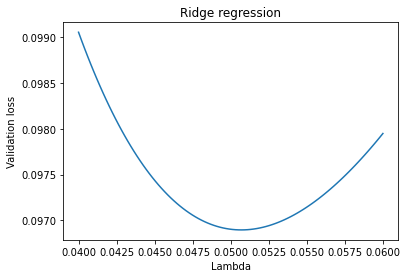

In [66]:
lambdas = np.linspace(0.04, 0.06, 100)
results = [compute_loss(y_val, tx_val, ridge_regression(y_tr, tx_tr, e)[0]) for e in lambdas]
plt.xlabel("Lambda")
plt.ylabel("Validation loss")
plt.title("Ridge regression")
plt.plot(lambdas, results)
print("Range : [0.04, 0.06]")
print("Nb of points : 100")

best_lambda = lambdas[np.argmin(results)]
print(f"Best lambda: {best_lambda}")

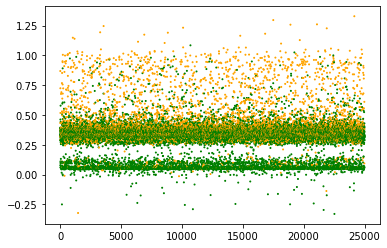

In [37]:
best_w_ridge, loss_train = ridge_regression(y_tr, tx_tr, best_lambda)
result_validation = tx_val@best_w_ridge
y_colors = ['green' if e == 0 else 'orange' for e in y_val]
plt.scatter(np.arange(0, y_val.shape[0]), result_validation, s=1, c=y_colors)

Validation loss

In [38]:
validation_loss = compute_loss(y_val, tx_val, best_w_ridge)
print(validation_loss)

0.10000240384523604


Predictions

In [28]:
y_pred = [-1 if e < 0.5 else 1 for e in test_tx_poly@best_w_ridge]
create_csv_submission(test_ids, y_pred, "submit_ridge.csv")

## Least squares

Training loss

In [550]:
best_w_ls, train_loss = least_squares(y_tr, tx_tr)
print(train_loss)

0.07325193847015908


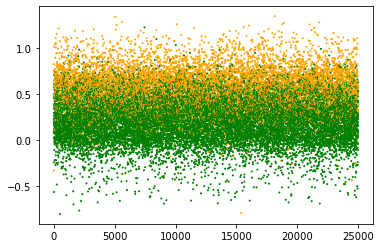

In [551]:
result_validation = tx_val@best_w_ls
y_colors = ['green' if e == 0 else 'orange' for e in y_val]
plt.scatter(np.arange(0, y_val.shape[0]), result_validation, s=1, c=y_colors)

Validation loss

In [552]:
validation_loss = compute_loss(y_val, tx_val, best_w_ls)
print(validation_loss)

0.07378593864285983


Predictions

In [203]:
y_pred = [-1 if e < 0.5 else 1 for e in test_tx_poly@best_w_ls]
create_csv_submission(test_ids, y_pred, "submit_ls.csv")

## Gradient descent

Training loss

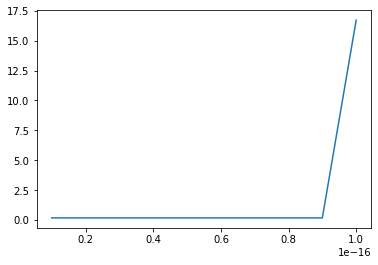

In [197]:
gammas = lambdas = np.linspace(0.00000000000000001, 0.0000000000000001, 10)
w_init = np.zeros(tx_tr.shape[1])

results = [compute_loss(y_val, tx_val, mean_squared_error_gd(y_tr, tx_tr, w_init, max_iter, e)[0]) for e in gammas]
best_gamma = gammas[np.argmin(results)]
plt.plot(gammas, results)

In [198]:
print(best_gamma)

7.999999999999999e-17


In [204]:
best_w_gd, train_loss_gd = mean_squared_error_gd(y_tr, tx_tr, w_init, max_iter, best_gamma)

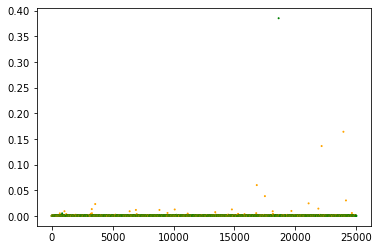

In [205]:
result_validation = tx_val@best_w_gd
y_colors = ['green' if e == 0 else 'orange' for e in y_val]
plt.scatter(np.arange(0, y_val.shape[0]), result_validation, s=1, c=y_colors)

Validation loss

In [207]:
validation_loss = compute_loss(y_val, tx_val, best_w_gd)
print(validation_loss)

0.17309492017248165


In [208]:
y_pred = [-1 if e < 0.5 else 1 for e in test_tx_poly@best_w_gd]
create_csv_submission(test_ids, y_pred, "submit_gd.csv")

## Stochastic gradient descent

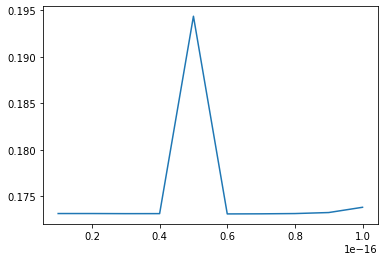

In [33]:
gammas = lambdas = np.linspace(0.00000000000000001, 0.0000000000000001, 10)
w_init = np.zeros(tx_tr.shape[1])

results = [compute_loss(y_val, tx_val, mean_squared_error_sgd(y_tr, tx_tr, w_init, max_iter, e)[0]) for e in gammas]
best_gamma = gammas[np.argmin(results)]
plt.plot(gammas, results)

In [34]:
print(best_gamma)

6e-17


In [35]:
best_w_sgd, train_loss_sgd = mean_squared_error_sgd(y_tr, tx_tr, w_init, max_iter, best_gamma)

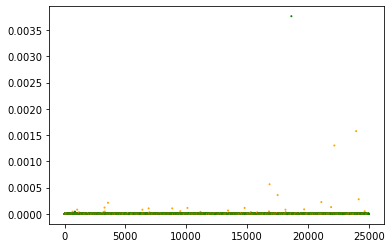

In [36]:
result_validation = tx_val@best_w_sgd
y_colors = ['green' if e == 0 else 'orange' for e in y_val]
plt.scatter(np.arange(0, y_val.shape[0]), result_validation, s=1, c=y_colors)

Validation loss

In [37]:
validation_loss = compute_loss(y_val, tx_val, best_w_sgd)
print(validation_loss)

0.1731197310693944


Predictions

In [39]:
y_pred = [-1 if e < 0.5 else 1 for e in test_tx_poly@best_w_sgd]
create_csv_submission(test_ids, y_pred, "submit_sgd.csv")